In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['megno']

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

# Fraction not chaotic over 1e4 orbits

In [4]:
(testX['megno']<2.5).sum()/testX['megno'].shape[0]

0.517

# Fraction not chaotic over 1e4 orbits that were stable

In [5]:
regular = testX['megno'] < 2.5
testY[regular].sum()/testY.shape[0]

0.2595

# Fraction chaotic over 1e4 orbits that were stable

In [6]:
chaotic = testX['megno'] > 2.5
testY[chaotic].sum()/testY.shape[0]

0.011

In [7]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [8]:
(trainX['megno']<2.5).sum()/trainX['megno'].shape[0]

0.510313789223653

In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.85218124                                          
ERROR                                               
0.004846380783358823                                
HOLDOUT SCORE                                       
0.8544796210404159                                  
SCORE:                                                                        
0.85445452                                                                    
ERROR                                                                         
0.006511875172976645                                                          
HOLDOUT SCORE                                                                 
0.8572763356767036                                                            
SCORE:                                                                        
0.85223792                                                                    
ERROR                                             

0.003699964207996508                                                           
HOLDOUT SCORE                                                                  
0.8495272507059883                                                             
SCORE:                                                                         
0.84963628                                                                     
ERROR                                                                          
0.004408448687178088                                                           
HOLDOUT SCORE                                                                  
0.8523429690657389                                                             
SCORE:                                                                         
0.8465792600000001                                                             
ERROR                                                                          
0.0020670745001331392                   

0.007042983491030104                                                           
HOLDOUT SCORE                                                                  
0.8582201872753602                                                             
SCORE:                                                                         
0.8540322399999999                                                             
ERROR                                                                          
0.006586410749637409                                                           
HOLDOUT SCORE                                                                  
0.8575803952521098                                                             
SCORE:                                                                         
0.8468868199999999                                                             
ERROR                                                                          
0.004317849581140372                    

In [10]:
best

{'x_learning_rate': 0.14592203032134907,
 'x_max_depth': 4,
 'x_min_child': 3.0,
 'x_pos_weight': 1.9632453385608362,
 'x_subsample': 0.8349449893817242,
 'x_tree_colsample': 0.5588430872405726}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.858285+0.00163938	test-auc:0.851712+0.00804324
[1]	train-auc:0.860793+0.00178694	test-auc:0.854712+0.0081525
[2]	train-auc:0.862363+0.00182349	test-auc:0.855636+0.00789503
[3]	train-auc:0.863246+0.00164311	test-auc:0.856677+0.00770875
[4]	train-auc:0.863524+0.001835	test-auc:0.85711+0.00790725
[5]	train-auc:0.863847+0.0017861	test-auc:0.857258+0.00797906
[6]	train-auc:0.864675+0.00162102	test-auc:0.857056+0.00779141
[7]	train-auc:0.864908+0.00155381	test-auc:0.857003+0.00737399
[8]	train-auc:0.865262+0.00153537	test-auc:0.856717+0.00705523
[9]	train-auc:0.865515+0.00145764	test-auc:0.856897+0.00703954
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.858285       0.001639       0.851712      0.008043
1        0.860793       0.001787       0.854712      0.008152
2        0.862363       0.001823       0.855636      0.007895
3        0.863246       0.001643       0.856677      0.007709
4        0.863524       0.001835       0.857110      0.007907
5  

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [12]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5588430872405726, gamma=0,
              learning_rate=0.14592203032134907, max_delta_step=0, max_depth=4,
              min_child_weight=3.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.9632453385608362,
              seed=None, silent=True, subsample=0.8349449893817242)

Text(0.5, 1.0, 'ROC curve (AUC = 0.853)')

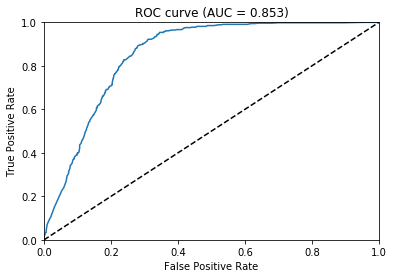

In [13]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [14]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.004862850997596979, recall = 1.0, precision = 0.2800207039337474
Threshold 0.029663799330592155, recall = 0.9963031423290203, precision = 0.3515981735159817
Threshold 0.04581496864557266, recall = 0.9907578558225508, precision = 0.3801418439716312
Threshold 0.07291742414236069, recall = 0.9815157116451017, precision = 0.4306569343065693
Threshold 0.10469625145196915, recall = 0.9759704251386322, precision = 0.45595854922279794
Threshold 0.14790281653404236, recall = 0.966728280961183, precision = 0.47074707470747074
Threshold 0.1947355419397354, recall = 0.9630314232902033, precision = 0.48782771535580527
Threshold 0.25186243653297424, recall = 0.9537892791127541, precision = 0.5063788027477919
Threshold 0.29607537388801575, recall = 0.922365988909427, precision = 0.5165631469979296
Threshold 0.37661242485046387, recall = 0.9038817005545287, precision = 0.5297941495124594
Threshold 0.4387975037097931, recall = 0.8946395563770795, precision = 0.5395763656633222
Threshold 0.4

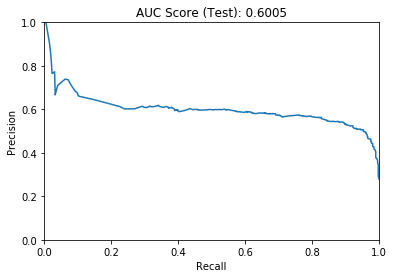

In [15]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 18.700000000000003)

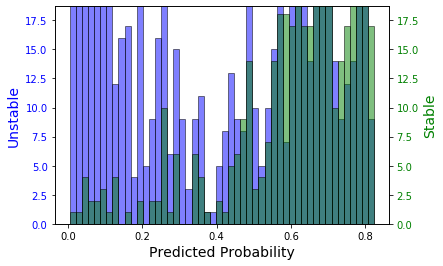

In [16]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

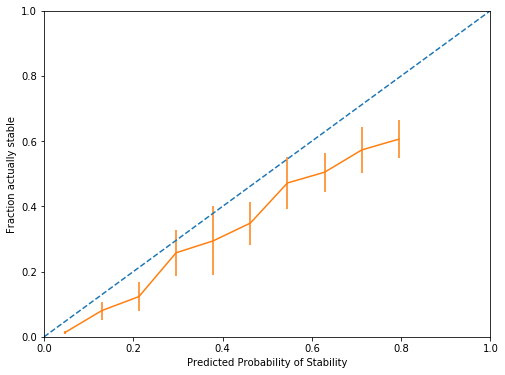

In [17]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

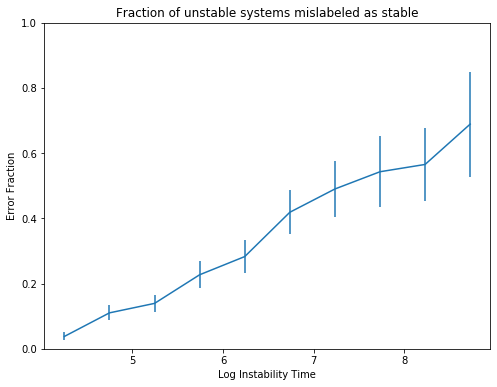

In [18]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

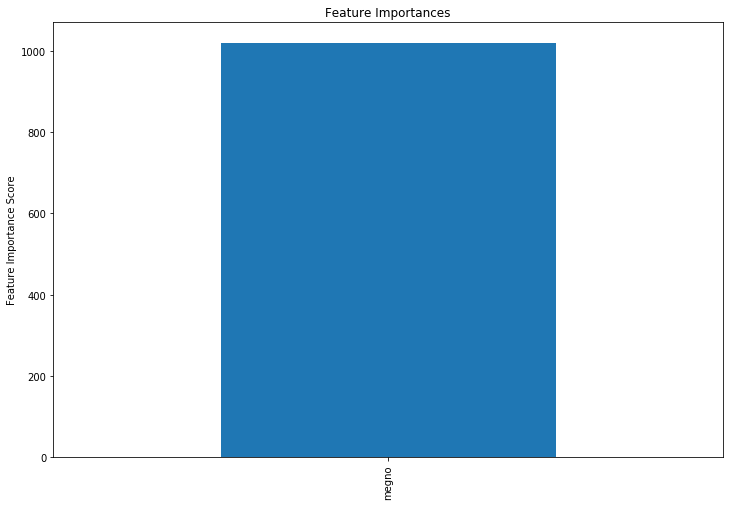

In [19]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [20]:
dill.dump([model, features, featurefolder], open(datapath+"../models/megnoxgb_resonant.pkl", "wb"))